In [110]:
import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, make_scorer, mean_squared_error 
import warnings
warnings.filterwarnings('ignore')

In [111]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [112]:
target = df_train['SalePrice']  
df_train = df_train.drop('SalePrice', axis=1) 
df_train['training_set'] = True 
df_test['training_set'] = False

data = pd.concat([df_train, df_test]) 

In [113]:
data = data.drop('Id', axis=1)

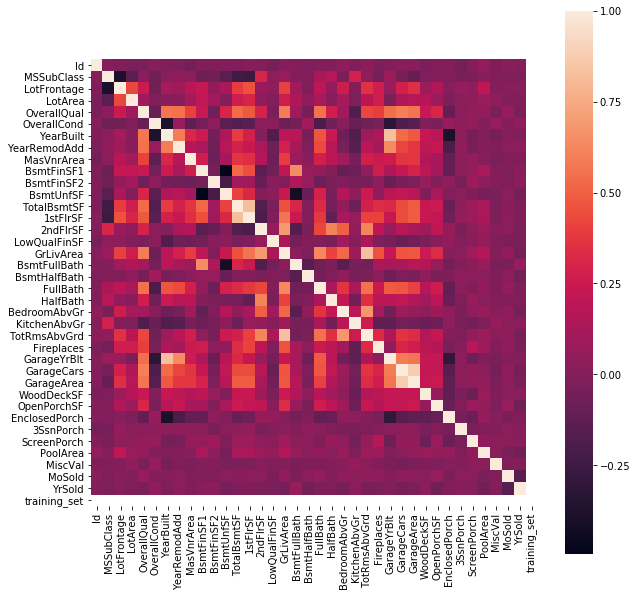

In [114]:
corrmat = df_train.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,square=True);

In [115]:
#логанем таргет
target = np.log(target)


In [116]:
#Отнормируем и уберем NaN
numeric_variables = list(data.select_dtypes(include=['int64', 'float64']).columns.values)
data[numeric_variables] = data[numeric_variables].apply(lambda x: x.fillna(x.median()),axis=0)

In [117]:
#Отнормируем и уберем NaN
categorial_variables = list(data.select_dtypes(exclude=['int64', 'float64', 'bool']).columns.values)
data[categorial_variables] = data[categorial_variables].apply(lambda x: x.fillna("None"),axis=0)

In [119]:
df_train = data[data['training_set']==True]
df_train = df_train.drop('training_set', axis=1)
df_test = data[data['training_set']==False]
df_test = df_test.drop('training_set', axis=1)

In [120]:
(df_train.shape, df_test.shape)

((1460, 310), (1459, 310))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, random_state=42)

### Random Forest

In [122]:
rf_model = RandomForestRegressor(n_estimators=110, n_jobs=-1, max_depth = 15, min_samples_leaf=2)

In [123]:
rf_model.fit(X_train, y_train)
y_predict = rf_model.predict(X_test)

###  XGBoost

In [124]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(random_state=42)

In [125]:
xgb_opt = xgb.XGBRegressor(
    learning_rate = 0.05,
    max_depth = 5,
    min_child_weight = 1.5,
    n_estimators = 7500,                                                                  
    seed = 42,
    silent = 1)

In [126]:
xgb_opt.fit(X_train, y_train)
xgb_opt_predict = xgb_opt.predict(X_test) 

### Lasso Regressor

In [127]:
from sklearn.linear_model import Lasso
lasso_regr = Lasso(random_state=42, max_iter = 30000, alpha = 0.001)

In [128]:
lasso_regr.fit(X_train, y_train)
lasso_opt_predict = lasso_regr.predict(X_test) 

### Сравним

In [129]:
rf_r2 = r2_score(y_test, y_predict)
rf_mse = mean_squared_error(y_test, y_predict)

xgb_r2 = r2_score(y_test, xgb_opt_predict)
xgb_mse = mean_squared_error(y_test, xgb_opt_predict)

lasso_r2 = r2_score(y_test, lasso_opt_predict)
lasso_mse = mean_squared_error(y_test, lasso_opt_predict)

In [130]:

d = {'RandomForest': [rf_r2, rf_mse], 
     'XGBoost': [xgb_r2, xgb_mse], 
     'Lasso': [lasso_r2, lasso_mse]}
d_i = ['R2', 'Mean Squared Error']
df_results = pd.DataFrame(data=d, index = d_i)


In [131]:
df_results

,RandomForest,XGBoost,Lasso
R2,0.888083,0.886499,0.899444
Mean Squared Error,0.019379,0.019654,0.017412
